HDF5 Files
----------

HDF5 is a file format (and library) that can be used to read and write large amount of data.
The primary storage object of HDF5 is the dataset, which is a one or multi-dimension array (similar to a Pandas Dataframe).  An HDF5 file can contain multiple datasets that can be organized with Groups (collections of links to datasets or other groups).  Attributes can be used to attach metadata
(data about the data) to groups or datasets.

Compared to CSV files, HDF5 has many advantages:

* Large arrays require less storage space (especially if the compression feature is used)
* There's no size limit to the size of the array
* Data can read as needed, rather than requiring all the data to be read first
* Data reads and writes are much faster than with CSV

There are a few downsides with HDF5 as well:

* Since the format is binary, you are dependent on software libaries to read or write the data
* Lots of (somewhat confusiong) options for how the data is stored: data types, compression, chunking, etc.
* No built in support for null elements
* Performance can be poor if accessed incorrectly  (examples later)

h5py
----

H5py is a Python package for reading and writing HDF5 files.  It provides a "Pythonic" interface to
the underlying C HDF5 libary.  It is easy to use while providing the ability to utilize more complexe HDF5 features if desired.

There are many other Python packages for HDF5: h5netdf, xarray, pytables, etc., but h5py is a good starting point as most HDF5 features are straightfowardly accessible in h5py.

In [1]:
# import h5py and matplotlib (plotting isn't built-in h5py like with pandas)
# numpy is an package for working with in-memory arrays
%matplotlib inline
import h5py
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# You can open or create new files using h5py.File
# We'll use "w" for mode to create a new file
# Use "r" for reading an existing file, or "a" to read and update

h5_filename = "Fremont_Bridge_Bicycle_Counter.h5"
f = h5py.File(h5_filename, mode="w")

In [3]:
# h5py.File returns a reference to a h5py.File object
isinstance(f, h5py.File)

True

In [4]:
# It is also a HDF5 Group - in this case a special group known as the root group.
# This is the base of the HDF5 heierachy for the file
isinstance(f, h5py.Group)

True

In [5]:
# It's easy to add an attribute, let's put in metadata about what we'll be storing
# You can add any number of attr they can be accessed using their name
f.attrs["Description"] = "This file contains bicyle count traffic for the Freemont Bridge in Seattle WA"
f.attrs["Frequency"] = "Hourly"
f.attrs["Date Range"] = ("10/02/2012 01:00:00 PM", "3/31/2024 11:00:00 PM")  
list(f.attrs)

['Date Range', 'Description', 'Frequency']

In [6]:
# We'll create 4 datasets for date, total, east, and west
# Alternatively we could have one dataset with 4 fields (known as a compund type)
num_rows = 100673  # the number of rows in our CSV file
max_rows = None    # we'll allow the datasets to be extensible.  Use None for unlimited extent
dtype = np.dtype("int32")  # we'll use 4-byte ints for the type of each dataset
chunks = (50000,)     # chunks define how the dataset is internally organized within the file
compression = "gzip" # set the compression to be used "gzip", "lzf", or None for no compression
for name in ("total", "east", "west"):
    f.create_dataset(name, (num_rows,), maxshape=(max_rows,), chunks=chunks, dtype=dtype, compression=compression)
list(f)


['east', 'total', 'west']

In [7]:
f["total"]

<HDF5 dataset "total": shape (100673,), type "<i4">

In [11]:
# Now we'll read from the CSV file an write to the HDF5 file
filepath = "Fremont_Bridge_Bicycle_Counter.csv"

buffer_size = chunks[0]
total_arr = np.zeros(buffer_size, dtype=dtype)
east_arr = np.zeros(buffer_size, dtype=dtype)
west_arr = np.zeros(buffer_size, dtype=dtype)
with open(filepath) as input:
    input.readline()  # skip the header
    index = 0
    while True:
        line = input.readline().strip()
        if not line:
            break  # done reading the CSV file
        fields = line.split(",")
        if not fields[1]:
            total_val = 0
        else:
            total_val = int(fields[1])
        if not fields[2]:
            west_val = 0
        else:
            west_val = int(fields[2])
        if not fields[3]:
            east_val = 0
        else:
            east_val = int(fields[3])
        total_arr[index % buffer_size] = total_val
        east_arr[index % buffer_size] = east_val
        west_arr[index % buffer_size] = west_val
        index += 1
        if index % buffer_size == 0:
            # write each array to the corresponding HDF5 dataset
            f["total"][index - buffer_size:  index] = total_arr
            f["east"][index - buffer_size:  index] = east_arr
            f["west"][index - buffer_size:  index] = west_arr
    print(f"read {index + 1} lines")


read 100764 lines


In [12]:
# close the file for writing
f.close()

In [13]:
# The HDF5 file uses < 14% of the storage space as the CSV file
! ls -lh  

total 3.9M
-rw-r--r-- 1 john john 3.4K Apr 15 08:44 01_intro.ipynb
-rw-r--r-- 1 john john 216K Apr 15 09:02 02_CSV_and_pandas.ipynb
-rw-r--r-- 1 john john 3.1M Apr 12 05:44 Fremont_Bridge_Bicycle_Counter_20240410.csv
-rw-r--r-- 1 john john 429K Apr 15 09:04 Fremont_Bridge_Bicycle_Counter.h5
-rw-r--r-- 1 john john 150K Apr 15 07:18 HDF5_and_5py.ipynb


In [14]:
# h5ls can show the objects in our new file
! h5ls Fremont_Bridge_Bicycle_Counter.h5

east                     Dataset {100673/Inf}
total                    Dataset {100673/Inf}
west                     Dataset {100673/Inf}


In [15]:
# let's re-open the file for reading
f = h5py.File(h5_filename, mode="r")
list(f)

['east', 'total', 'west']

In [17]:
# get a handle to the "east" dataset.  This doesn't actually return the data,
# just metadata (type, shape, etc.) about the dataset itself
east_dset = f["east"]
east_dset

<HDF5 dataset "east": shape (100673,), type "<i4">

In [18]:
# We can read any selection of the data
# Data will get uncompressed as read
east_dset[12345:12345+10]

array([17, 10, 10,  2,  0,  0,  1,  3,  4, 13], dtype=int32)

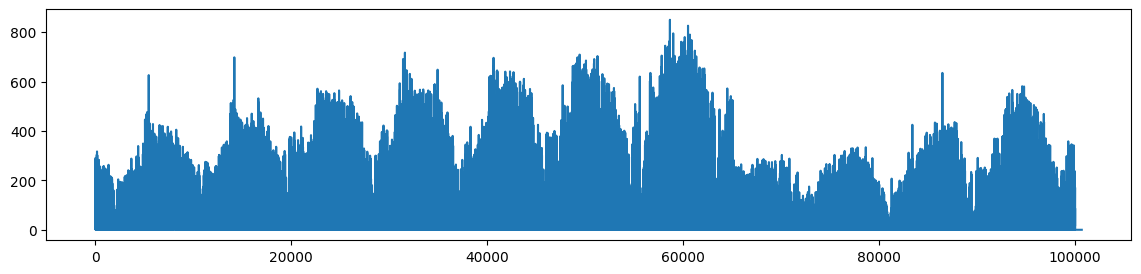

In [19]:
# we can use matplotlib to plot the data
plt.figure(figsize=(14,3))
plt.plot(east_dset[:])

In [20]:
# you can use a stride factor to select every nth element
# Let's grab every 24th element to get the value a 1pm for each day
east_1pm = east_dset[::24]
east_1pm.min(), east_1pm.max(), east_1pm.mean()


(0, 456, 57.12491060786651)

In [21]:
# data at 1 am should be a bit less
east_1am = east_dset[12::24]  # 1am data starts at index 12 and every 24th row thereafter
east_1am.min(), east_1am.max(), east_1am.mean()

(0, 40, 2.974016686531585)

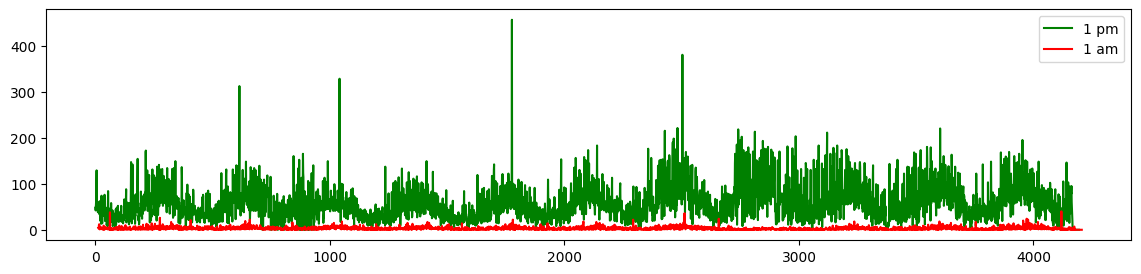

In [22]:
# Use matplot lib to plot 1pm and 1am data
plt.figure(figsize=(14,3))
index_1pm = np.arange(0, len(east_1pm))
plt.plot(index_1pm, east_1pm, color='g', label='1 pm') 
index_1am = np.arange(12, len(east_1am) + 12)
plt.plot(index_1am, east_1am, color='r', label='1 am')
plt.legend()
plt.show()

In [32]:
# We can use a similar technique to get the mean count for each hour
histo_data = []
histo_index = []
for i in range(24):
    start = (i + 11) % 24  # midnight to midnight with 1pm first entry  
    arr = east_dset[start::24]  # returns all the entries for that hour
    avg_count = arr.mean()  # compute the average count
    # add the hour to the index list
    if i == 0:
        label = "12 am"
    elif i < 12:
        label = f"{i} am"
    elif i == 12:
        label = "12 pm"
    else:
        label = f"{i-12} pm"
    print(f"{label:>6}: {avg_count:8.2f}")
    histo_data.append(avg_count)
    histo_index.append(label)

 12 am:     5.68
  1 am:     2.97
  2 am:     1.98
  3 am:     1.38
  4 am:     3.35
  5 am:    11.66
  6 am:    40.65
  7 am:   100.71
  8 am:   148.18
  9 am:    94.25
 10 am:    54.54
 11 am:    49.87
 12 pm:    53.84
  1 pm:    57.12
  2 pm:    64.24
  3 pm:    82.20
  4 pm:   136.46
  5 pm:   215.73
  6 pm:   138.41
  7 pm:    70.02
  8 pm:    39.61
  9 pm:    25.51
 10 pm:    16.43
 11 pm:    10.68


<BarContainer object of 24 artists>

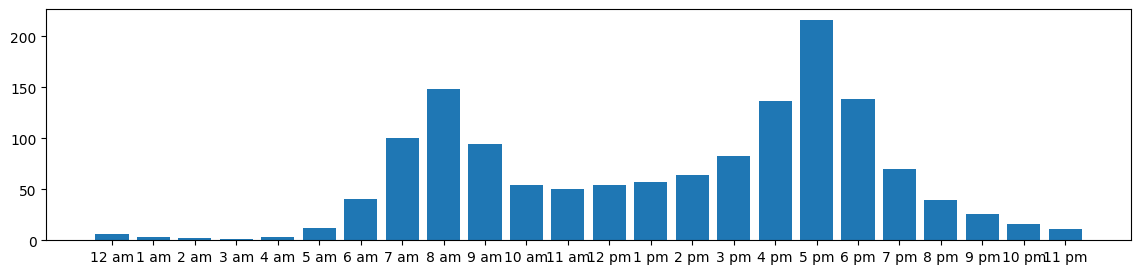

In [33]:
# make a bar plot
plt.figure(figsize=(14,3))
plt.bar(histo_index, histo_data)